# Laboratorio No 4 - Descenso por Gradiente

# Grupo 1: Nicolás De León, Matías Larroque

# Profesor: Marc Ressl

# ITBA


In [ ]:
import os
import math
from math import e

from IPython.display import Audio, clear_output
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import toeplitz, inv
from scipy import signal
from scipy.io import wavfile

En este trabajo se pretende analizar el método de descenso por gradiente, para lo cual se imlpementará un filtro de Wiener a partir de la siguiente plantilla

## Plantilla para descenso por gradiente

In [ ]:
if not os.path.exists('plantillaTP4.PNG'):
  !wget "https://raw.githubusercontent.com/mlarroque/Adaptative-Processing-1/master/TP4/plantillaTP4.PNG"

if not os.path.exists('tamaraSong.wav'):
  !wget "https://raw.githubusercontent.com/mlarroque/Adaptative-Processing-1/master/TP4/tamaraSong.wav"

clear_output()

plantilla_img = plt.imread("plantillaTP4.PNG")

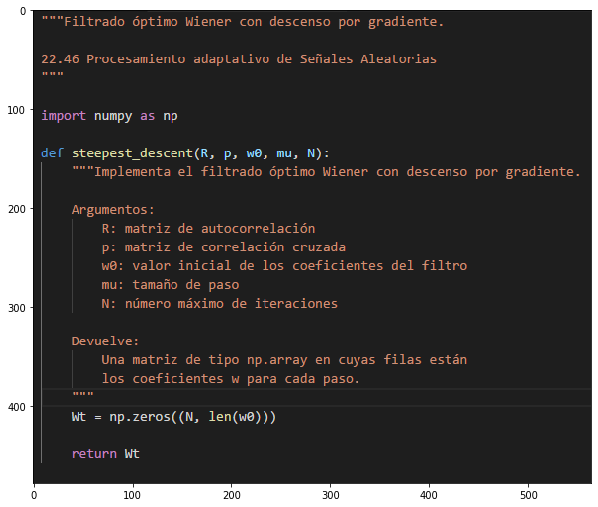

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plantilla_img, interpolation='nearest')

# 1. Implementar el filtrado óptimo Wiener con descenso por gradiente

Para el cálculo del filtro óptimo con el método de descenso por gradiente, debe aplicarse

$$ w(n+1) = w(n) - 0.5 \mu \nabla{J} $$

siendo $ \nabla{J} $ el gradiente de la función de costo $ J(n) $

$$ \nabla{J} = -2p + 2 R w(n) $$.

Esto nos deja, entonces $$ w(n+1) - w(n) = \mu (p - R w(n))   $$

In [ ]:
def steepest_descent(R, p, w0, mu, N):
    """Filtrado óptimo Wiener con descenso por gradiente.

    22.46 Procesamiento adaptativo de Señales Aleatorias

    Implementa el filtrado óptimo Wiener con descenso por gradiente.
     
    Argumentos:
        R: matriz de autocorrelación
        p: matriz de correlación cruzada
        w0: valor inicial de los coeficientes del filtro
        mu: tamaño de paso
        N: número máximo de iteraciones

    Devuelve:
        Una matriz de tipo np.array en cuyas filas están
        los coeficientes w para cada paso.
    """

    Wt = np.zeros((N, len(w0)))
    Wt[0, :] = w0
    R = np.array(R)

    for i in range(N - 1):
      Wt[i + 1, :] = Wt[i, :] + mu * (p - R.dot(Wt[i, :]))

    return Wt

# 2. Prueba de función con argumentos

Procedemos a probar la función steepest descent

In [ ]:
R = [[2, 1],
     [1, 2]]
p = [6, 4]
mu = 0.1
w0 = [0, 0]
N = 1000
sigma2_d = 20

Wt = steepest_descent(R, p, w0, mu, N)

Representación de los coeficientes del filtro en función de los pasos ("n") y comparación con el método directo de las ecuaciones de Wiener Hopfman

In [ ]:
print(Wt)

[[0.         0.        ]
 [0.6        0.4       ]
 [1.04       0.66      ]
 ...
 [2.66666667 0.66666667]
 [2.66666667 0.66666667]
 [2.66666667 0.66666667]]


Buscamos comparar graficamente el método realizado con el tradicional Wiener - Hopf. Para lo cual definimos `` compare_modes ``.

In [ ]:
def compare_modes(R, p, sigma2_d, Wt):
    """ Resultados según el método directo con ecuaciones de Wiener - Hopfman
    vs Steepest descent """

    Rinv = inv(R)
    Wo_hopfman = np.dot(Rinv, p)
    jmin_hopfman = sigma2_d - np.dot(p, Wo_hopfman)

    plt.figure()
    plt.plot(Wt[:, 0])
    plt.plot(Wt[:, 1])
    plt.plot(np.ones(len(Wt[:, 0])) * Wo_hopfman[0])
    plt.plot(np.ones(len(Wt[:, 1])) * Wo_hopfman[1])
    plt.xlim(0, 100)
    plt.legend(("w1 - Steepest", "w2 - Steepest", "w1 - Hopfman", "w2 - Hopfman"))  

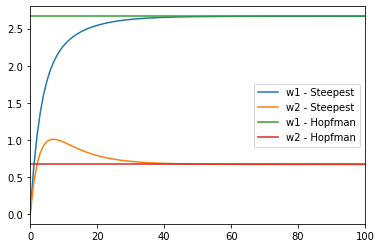

In [ ]:
compare_modes(R, p, sigma2_d, Wt)

Se observa de la comparación gráfica, que los coeficientes obtenidos por el metodo de Steepest Descent convergen a los coeficientes del filtro obtenido por el método directo de Wiener - Hopf.
Según el gráfico ambos convergen a la misma velocidad, con la diferencia que el segundo coeficiente lo hace con una oscilación. A los 35 pasos aproximadamente, los coeficientes ya corresponden a los óptimos.

# 3. Curva de error J

Buscaremos ahora realizar el cálculo y representación de la curva de error $ J(w) $

In [ ]:
def calculate_J(R, p, sigma2_d, Wt):
    """
    Realiza el cálculo de J y devuelve a su vez el cálculo de Jmin por Wiener - Hopf
    """
    N = len(Wt[:, 0])
    Wt = np.array(Wt)
    p = np.array(p)
    R = np.matrix(R)
    J_w_n = [
            sigma2_d - (Wt[k, :].T).dot(p) - (p.T).dot(Wt[k, :]) + \
            (Wt[k, :].T).dot(np.array(R.dot(Wt[k, :]))[0]) for k in range(N)
            ]

    # Wiener_Hopfman directo
    Rinv = inv(R)
    Wo_hopfman = np.dot(Rinv, p)
    jmin_hopfman = sigma2_d - np.dot(p, Wo_hopfman)
    return J_w_n, jmin_hopfman

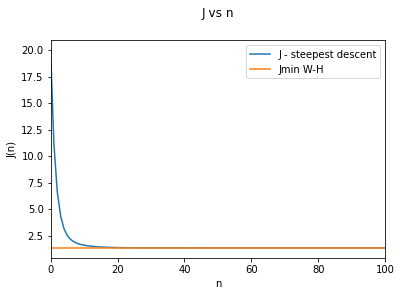

In [ ]:
J_w_n , jmin_hopfman= calculate_J(R, p, sigma2_d, Wt)

plt.figure();
plt.plot(J_w_n);
plt.plot(np.ones(len(J_w_n)) * jmin_hopfman);
plt.xlim(0, 100);
plt.title("J vs n", y=1.08);
plt.ylabel("J(n)");
plt.xlabel("n");
plt.legend(("J - steepest descent", "Jmin W-H"));

Podemos observar del gráfico la convergencia del $ J $ que resulta de cada iteración por el metodo de Steepest Descent al $ J_{min} $ calculado por Wiener - Hopf. 

A partir del gráfico se puede decir que el método de descenso por gradiente consigue un filtro cercano al óptimo con aproximadamente 15 pasos ya que en este número de pasos la curva de J se aproxima a la asíntota del Jmin.

Entonces, a los 15 pasos se obtiene un filtro aceptable, aunque aún no se tengan los coeficientes óptimos.

# 4. Elección del paso a partir de los autovalores de la matriz R (matriz de autocorrelación de la señal de entrada)


In [ ]:
def get_mu_max(R):
  avas_R, aves_R = np.linalg.eig(R)
  mu_max = 2 / np.max(avas_R)
  return mu_max, avas_R, aves_R

mu_max = 0.6666666666666666
mu = 0.1 <UP> - mu = 0.95 * mu_max = 0.6333333333333333 <DOWN


'\ntao_k = 1 / (mu_choosen * lambdas)\n\nx = np.linspace(0, 20, 100)\n\nexp_w1 = np.array([e**-(i / tao_k[0]) for i in x])\nexp_w1 *= sum(v0_k[0, :] * v0_k[0, :])\nexp_w1 += Wt_2[100, 0] \n\nexp_w2 = np.array([e**-(i / tao_k[1]) for i in x])\nexp_w2 *= sum(v0_k[1, :] * v0_k[1, :])\nexp_w2 += Wt_2[100, 1]\n\nplt.plot(exp_w1);\nplt.plot(exp_w2);\n'

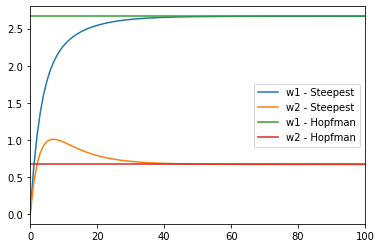

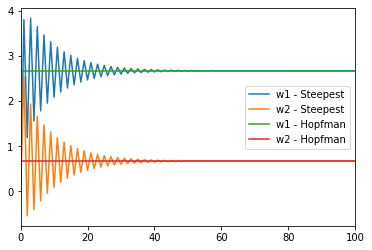

In [ ]:
mu_max, lambdas, v0_k = get_mu_max(R)
print(f'mu_max = {mu_max}')

mu_choosen = 0.95 * mu_max

print(f'mu = 0.1 <UP> - mu = 0.95 * mu_max = {mu_choosen} <DOWN')
Wt_1 = steepest_descent(R, p, w0, 0.1, N)
Wt_2 = steepest_descent(R, p, w0, mu_choosen, N)

compare_modes(R, p, sigma2_d, Wt_1)
compare_modes(R, p, sigma2_d, Wt_2)


#Se pretende graficar las exponenciales que envuelve la curva J(w)
"""
tao_k = 1 / (mu_choosen * lambdas)

x = np.linspace(0, 20, 100)

exp_w1 = np.array([e**-(i / tao_k[0]) for i in x])
exp_w1 *= sum(v0_k[0, :] * v0_k[0, :])
exp_w1 += Wt_2[100, 0] 

exp_w2 = np.array([e**-(i / tao_k[1]) for i in x])
exp_w2 *= sum(v0_k[1, :] * v0_k[1, :])
exp_w2 += Wt_2[100, 1]

plt.plot(exp_w1);
plt.plot(exp_w2);
"""

Se puede observar que con un valor de parámetro de paso cercano al máximo (95% del máximo) se logra la convergencia, aunque con oscilaciones cuya envolvente es una función exponencial decreciente. 

En cuanto a la velocidad de convergencia, comparandola con la de un parámetro de paso relativamente pequeño (aproximadamente un 18% del valor máximo), no se puede observar según los gráficos una diferencia de velocidad.

Esto quiere decir que la velocidad de convergencia no es directamente proporcional al parámetro de paso, ya que pueden existir oscilaciones que no permiten acelerar la convergencia al aumentar este parámetro.

# 5. Análisis cuando $ R $ y $ p $ varían en el tiempo

El metodo de descenso por gradiente nos permite justar los coeficientes del filtro a medida que transcurre el tiempo con las estimaciones de $ p $  y de $ R $ donde el ajuste sobre el $ W $ anterior queda definido

 $$ \delta{w(n)} = \mu [p - Rw(n)] $$ 

Es crucial que el cambio que se realice en el tiempo, sea lo suficientemente grande para que se puedan realizar la cantidad de ajustes necesarios para converger al valor deseado. Si las variaciones de $ p $ y $ R $ son muy grandes o muy rápidas, puede que el algoritmo no pueda converger al nuevo valor del filtro.

Teniendo esto en cuenta, teniendo una capacidad de procesamiento suficiente, el algoritmo permite la adaptación.

Si se aplicase en cambio el método directo con las ecuaciones de Wiener Hopf, la capacidad de adaptación sería menor, debido a la necesidad de invertir la matriz de autocorrelación de la entrada.


# 6. Filtrado de una señal de música

### Análisis de código de prueba

A continuación se procede a analizar los resultados del siguiente código

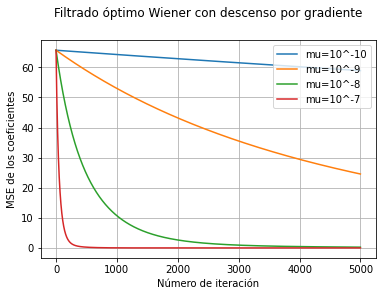

In [ ]:
def simulate_channel(y, snr_db):
    """Prueba de filtrado óptimo Wiener con descenso por gradiente.

    22.46 Procesamiento adaptativo de Señales Aleatorias

    Simula un canal
    """

    w = [1.0000, 2.4156, 2.2226, 0.9578, 0.1884, 0.0130];
    u = signal.filtfilt(1, w, y);

    Pmeas = np.var(y); # Añade ruido blanco
    snr = 10 ** (snr_db / 10);
    P_noise = Pmeas / snr;
    additive_white_noise = math.sqrt(P_noise) * np.random.randn(*u.shape);

    u = np.round(u + additive_white_noise); # Simula cuantización

    return (u, w)

fs, d = wavfile.read('tamaraSong.wav')      # Lee archivo de entrada
d = np.float32(d)

u, w_true = simulate_channel(d, 80);        # Simula un canal

s_start = 8;                                # Extrae segmentos de un segundo de ambas señales
d = d[s_start * fs:(s_start + 1) * fs];
u = u[s_start * fs:(s_start + 1) * fs];

N_THETA = 6;                                # Estima la autocorrelación y correlación cruzada
r = np.correlate(u, u, 'full') / len(u);
r = r[(len(u) - 1):len(u) - 1 + N_THETA];
R = toeplitz(r);

p = np.correlate(d, u, 'full') / len(u);
p = p[(len(u) - 1):len(u) - 1 + N_THETA];

w_wiener = inv(R).dot(p);                   # Determina el filtro óptimo Wiener

mus = [1e-10, 1e-9, 1e-8, 1e-7];            # Encuentra el filtro óptimo Wiener con descenso por gradiente para distintos pasos
w0 = np.zeros(N_THETA);

N = 5000;                                   # Número de iteraciones

for mu in mus:

    # Llama a la función de filtrado óptimo Wiener con descenso por gradiente.
    # Las filas de Wt representan los filtros en diferentes instantes.
    Wt = steepest_descent(R, p, w0, mu, N);

    # Calcula instante a instante el error cuadrático medio de los
    # coeficientes del filtro respecto de los coeficientes del filtro óptimo.
    mse_coeffs = np.mean((Wt - w_wiener) ** 2, 1)

    plt.plot(mse_coeffs, label='mu=10^%i' % math.log10(mu))

plt.xlabel('Número de iteración')
plt.ylabel('MSE de los coeficientes')
plt.title('Filtrado óptimo Wiener con descenso por gradiente', y=1.08)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

Podemos observar que para los valores de $ \mu $ $ 10⁻¹⁰, 10⁻⁹ $ en el número de iteraciones pre-definido de 5000 no se logra la convergencia. Esto se debe a que hay ciertos modos con $ \lambda $ pequeños que se ven muy desfavorecidos por el valor de $ \mu $ seleccionado. 


Por otra parte, los valores de $ \mu $ $ 10⁻⁷$ y $ 10⁻⁸ $ nos presentan dos casos en los que la convergencia se da para el número de iteraciones (5000) planteado, sin observar divergencias. Esto nos indica que posiblemente el valor de $ \mu $ es menor para $ \frac{2}{\lambda_{max}} $ lo que nos permite elegir estos valores y, frente al caso anterior, asegurar la convergencia de modos en los que los $ \lambda $ son chicos.

### Observemos que sucede si utilizamos un paso $ \mu = 10⁻⁶ $

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until


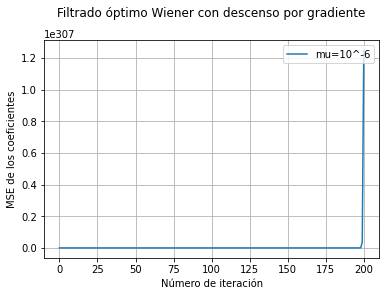

In [ ]:
Wt = steepest_descent(R, p, w0, mu=1e-6, N=5000);

mse_coeffs = np.mean((Wt - w_wiener) ** 2, 1);
plt.plot(mse_coeffs, label='mu=10^%i' % math.log10(1e-6));
plt.xlabel('Número de iteración');
plt.ylabel('MSE de los coeficientes');
plt.title('Filtrado óptimo Wiener con descenso por gradiente', y=1.08);
plt.grid(True);
plt.legend(loc='upper right');
plt.show();

Para un valor de $ \mu $ de $ 10⁻⁶ $ podemos ver que el sistema diverge, dado que el $ \mu $ seleccionado esta por encima de nuestra condición de convergencia, donde necesitamos que se cumpla $ 0 < \mu < \frac{2}{\lambda_{max}} $.